In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
import numpy as np
from tqdm import tqdm

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

Using device: cuda


In [3]:
class Autoencoder(nn.Module):
    def __init__(self, input_dim=784, hidden_dim=64, bottleneck_dim=32):
        super().__init__()
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, bottleneck_dim)
        )
        self.decoder = nn.Sequential(
            nn.Linear(bottleneck_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, input_dim),
            nn.Sigmoid()
        )
        self.bottleneck_dim = bottleneck_dim

    def forward(self, x):
        x = x.view(x.size(0), -1)
        z = self.encoder(x)
        x_recon = self.decoder(z)
        return x_recon, z

In [4]:
def column_normalize(grad):
    norm = torch.norm(grad, dim=0, keepdim=True) + 1e-8
    return grad / norm

class CustomOptimizer:
    def __init__(self, model, mode='sgd', lr=0.01, momentum=0.9):
        self.model = model
        self.mode = mode
        self.lr = lr
        self.momentum = momentum
        self.last_layer_momentum = None

        # Инициализация состояний
        if 'adam' in mode.lower():
            self.optim = optim.Adam(model.parameters(), lr=lr)
        else:
            self.optim = None  # будем обновлять вручную

    def zero_grad(self):
        if self.optim:
            self.optim.zero_grad()
        else:
            self.model.zero_grad()

    def step(self):
        if self.optim:
            self.optim.step()
        else:
            with torch.no_grad():
                for name, param in self.model.named_parameters():
                    if param.grad is None:
                        continue

                    grad = param.grad.clone()

                    if self.mode == 'sgd':
                        update = grad

                    elif self.mode == 'col_norm':
                        if param.ndim == 2:
                            update = column_normalize(grad)
                        else:
                            update = grad / (grad.norm() + 1e-8)

                    elif self.mode == 'last_mom':
                        update = grad
                        if name == 'decoder.2.weight':  # последний слой
                            if self.last_layer_momentum is None:
                                self.last_layer_momentum = torch.zeros_like(grad)
                            self.last_layer_momentum = self.momentum * self.last_layer_momentum + (1 - self.momentum) * grad
                            update = self.last_layer_momentum

                    elif self.mode == 'scale':
                        # col-norm + last-layer momentum
                        if param.ndim == 2:
                            normalized = column_normalize(grad)
                        else:
                            normalized = grad / (grad.norm() + 1e-8)

                        if name == 'decoder.2.weight':
                            if self.last_layer_momentum is None:
                                self.last_layer_momentum = torch.zeros_like(normalized)
                            self.last_layer_momentum = self.momentum * self.last_layer_momentum + (1 - self.momentum) * normalized
                            update = self.last_layer_momentum
                        else:
                            update = normalized

                    else:
                        raise ValueError(f"Unknown mode: {self.mode}")

                    param -= self.lr * update

In [5]:
transform = transforms.Compose([transforms.ToTensor()])
train_dataset = datasets.FashionMNIST(root='./data', train=True, download=True, transform=transform)
train_loader = DataLoader(train_dataset, batch_size=256, shuffle=True)

In [6]:
def train_autoencoder(mode, lr=0.01, epochs=15):
    model = Autoencoder().to(device)
    optimizer = CustomOptimizer(model, mode=mode, lr=lr, momentum=0.9)
    criterion = nn.MSELoss()
    losses = []

    for epoch in range(epochs):
        epoch_loss = 0
        for data, _ in tqdm(train_loader, desc=f"{mode} | Epoch {epoch+1}", leave=False):
            data = data.to(device)
            optimizer.zero_grad()
            recon, _ = model(data)
            loss = criterion(recon, data.view(data.size(0), -1))
            loss.backward()
            optimizer.step()
            epoch_loss += loss.item()
        avg_loss = epoch_loss / len(train_loader)
        losses.append(avg_loss)
        if (epoch + 1) % 5 == 0:
            print(f"  Epoch {epoch+1}: Loss = {avg_loss:.5f}")
    return model, losses

In [7]:
modes = ['sgd', 'col_norm', 'last_mom', 'scale', 'adam']
results = {}

for mode in modes:
    print(f"\n Training with {mode.upper()}")
    lr = 0.001 if mode == 'adam' else 0.1
    model, losses = train_autoencoder(mode, lr=lr, epochs=20)
    results[mode] = {'model': model, 'losses': losses}


 Training with SGD


  Epoch 5: Loss = 0.14801


  Epoch 10: Loss = 0.09376


  Epoch 15: Loss = 0.09078


  Epoch 20: Loss = 0.08732

 Training with COL_NORM


  Epoch 5: Loss = 0.04661


  Epoch 10: Loss = 0.04399


  Epoch 15: Loss = 0.04439


  Epoch 20: Loss = 0.04224

 Training with LAST_MOM


  Epoch 5: Loss = 0.16375


  Epoch 10: Loss = 0.09727


  Epoch 15: Loss = 0.09198


  Epoch 20: Loss = 0.08908

 Training with SCALE


  Epoch 5: Loss = 0.04535


  Epoch 10: Loss = 0.04332


  Epoch 15: Loss = 0.04241


  Epoch 20: Loss = 0.04024

 Training with ADAM


  Epoch 5: Loss = 0.01890


  Epoch 10: Loss = 0.01616


  Epoch 15: Loss = 0.01454


  Epoch 20: Loss = 0.01360


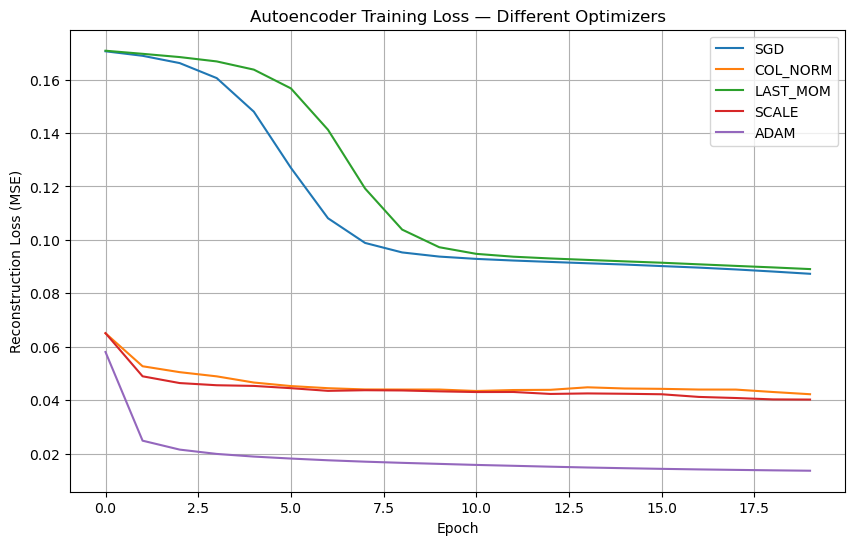

In [8]:
plt.figure(figsize=(10, 6))
for mode in modes:
    plt.plot(results[mode]['losses'], label=mode.upper())
plt.xlabel('Epoch')
plt.ylabel('Reconstruction Loss (MSE)')
plt.title('Autoencoder Training Loss — Different Optimizers')
plt.legend()
plt.grid(True)
plt.show()

In [10]:
# Возьмём один батч из тестовой выборки
test_dataset = datasets.FashionMNIST(root='./data', train=False, download=True, transform=transform)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)
test_images, _ = next(iter(test_loader))
test_images = test_images.to(device)

In [11]:
# Восстановление изображений
reconstructions = {}
with torch.no_grad():
    for mode in modes:
        model = results[mode]['model']
        model.eval()
        recon, _ = model(test_images)
        reconstructions[mode] = recon.view(-1, 28, 28).cpu().numpy()

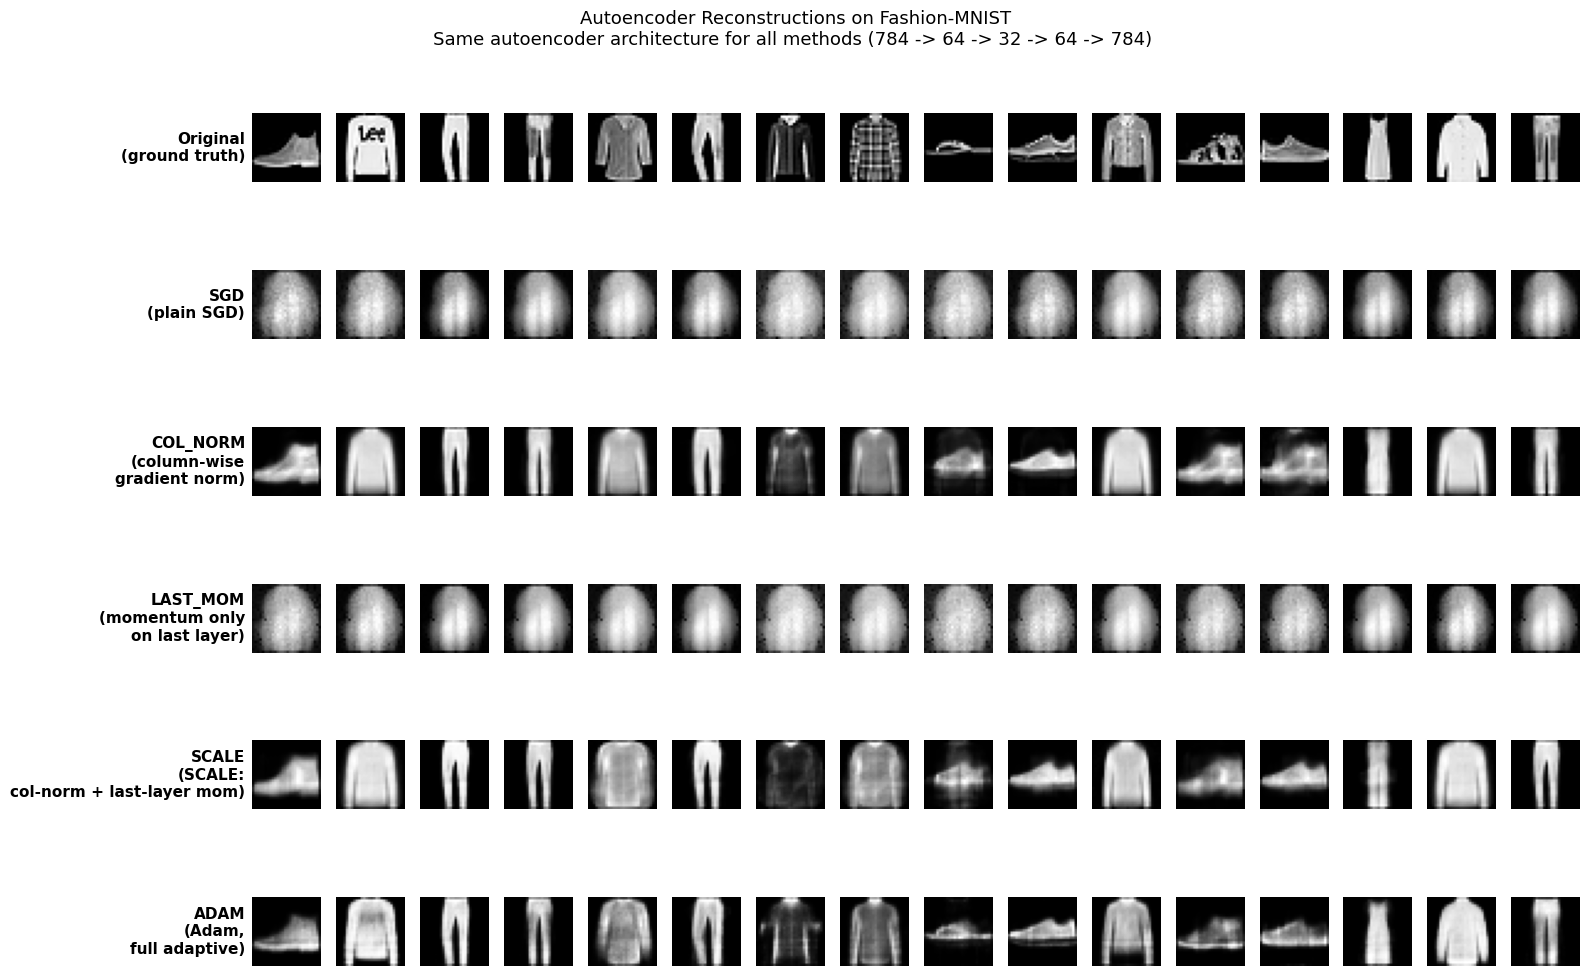

In [13]:
fig, axes = plt.subplots(len(modes) + 1, 16, figsize=(16, 10))

plt.style.use('default')

# Оригиналы
for j in range(16):
    axes[0, j].imshow(test_images[j].cpu().view(28, 28), cmap='gray')
    axes[0, j].axis('off')

axes[0, 0].text(
    -0.1, 0.5, 'Original\n(ground truth)',
    transform=axes[0, 0].transAxes,
    fontsize=11,
    verticalalignment='center',
    horizontalalignment='right',
    color='black',
    weight='bold'
)

# Реконструкции по методам
for i, mode in enumerate(modes):
    for j in range(16):
        axes[i+1, j].imshow(reconstructions[mode][j], cmap='gray')
        axes[i+1, j].axis('off')
    
    label_text = mode.upper()
    if mode == 'sgd':
        label_text += "\n(plain SGD)"
    elif mode == 'col_norm':
        label_text += "\n(column-wise\ngradient norm)"
    elif mode == 'last_mom':
        label_text += "\n(momentum only\non last layer)"
    elif mode == 'scale':
        label_text += "\n(SCALE:\ncol-norm + last-layer mom)"
    elif mode == 'adam':
        label_text += "\n(Adam,\nfull adaptive)"
    
    axes[i+1, 0].text(
        -0.1, 0.5, label_text,
        transform=axes[i+1, 0].transAxes,
        fontsize=11,
        verticalalignment='center',
        horizontalalignment='right',
        color='black',
        weight='bold'
    )

plt.tight_layout()
plt.suptitle(
    'Autoencoder Reconstructions on Fashion-MNIST\n'
    'Same autoencoder architecture for all methods (784 -> 64 -> 32 -> 64 -> 784) \n',
    y=1.03, fontsize=13, ha='center', color='black'
)
plt.show()